### Import packages & load data

In [1]:
import pandas as pd
import numpy as np
import pywt
from scipy.signal import iirnotch, filtfilt, butter
from scipy.ndimage import binary_closing, binary_opening
from scipy.stats import entropy, skew

#data = pd.read_csv('../data/blinks_256Hz.csv')
data = pd.read_csv('../data/3min_gradcpt_256Hz.csv')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
data.head(10)

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements
0,2024-02-29 15:06:50.456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/muse/event/connected Muse-AB4C
1,2024-02-29 15:06:50.504,0.468852,-0.116581,0.267672,0.729265,0.287714,-0.319277,-0.226728,0.504907,0.236323,...,4.306641,-4.934692,-0.605621,1.0,1.0,1.0,1.0,1.0,30.0,NaN
2,2024-02-29 15:06:50.505,0.468852,-0.118440,0.328742,0.729265,0.287714,-0.319458,-0.189798,0.504907,0.236323,...,4.306641,-4.934692,-0.605621,1.0,1.0,1.0,1.0,1.0,30.0,NaN
3,2024-02-29 15:06:50.506,0.468852,-0.118440,0.328742,0.729265,0.287714,-0.319458,-0.189798,0.504907,0.236323,...,4.306641,-4.934692,-0.605621,1.0,1.0,1.0,1.0,1.0,30.0,NaN
4,2024-02-29 15:06:50.507,0.468852,-0.118440,0.328742,0.729265,0.287714,-0.319458,-0.189798,0.504907,0.236323,...,4.306641,-4.934692,-0.605621,1.0,1.0,1.0,1.0,1.0,30.0,NaN
5,2024-02-29 15:06:50.507,0.468852,-0.118440,0.328742,0.729265,0.287714,-0.319458,-0.189798,0.504907,0.236323,...,4.306641,-4.934692,-0.605621,1.0,1.0,1.0,1.0,1.0,30.0,NaN
6,2024-02-29 15:06:50.508,0.468852,-0.118440,0.328742,0.729265,0.287714,-0.319458,-0.189798,0.504907,0.236323,...,4.306641,-4.934692,-0.605621,1.0,1.0,1.0,1.0,1.0,30.0,NaN
7,2024-02-29 15:06:50.508,0.468852,-0.118440,0.328742,0.729265,0.287714,-0.319458,-0.189798,0.504907,0.236323,...,4.306641,-4.934692,-0.605621,1.0,1.0,1.0,1.0,1.0,30.0,NaN
8,2024-02-29 15:06:50.508,0.468852,-0.118440,0.328742,0.729265,0.287714,-0.319458,-0.189798,0.504907,0.236323,...,4.306641,-4.934692,-0.605621,1.0,1.0,1.0,1.0,1.0,30.0,NaN
9,2024-02-29 15:06:50.509,0.468852,-0.118440,0.328742,0.729265,0.287714,-0.319458,-0.189798,0.504907,0.236323,...,4.306641,-4.934692,-0.605621,1.0,1.0,1.0,1.0,1.0,30.0,NaN


In [163]:
# TODO: handle missing values in a better fashion (interpolation?)
channels = ['RAW_AF8']
af8 = data[channels]
af8 = af8.drop(af8.index[:2000]) # beginning of the sample recording very noisy
af8 = af8.dropna()

### z-normalization

In [164]:
mean = af8['RAW_AF8'].mean()
std = af8['RAW_AF8'].std()
af8['AF8_normal'] = (af8['RAW_AF8'] - mean) / std

### Artifact removal

In [165]:
# Remove the 50Hz power line artifact
fs = 256
f0 = 50
quality_factor = 30

b, a = iirnotch(f0, quality_factor, fs)
af8['AF8_filt'] = filtfilt(b, a, af8['AF8_normal'])

# Remove EOG artifacts
threshold = 3
window_ms = 450 # Duration of the EOG event window in milliseconds (from zhang et al)
window_samples = int((window_ms / 1000) * fs) # Convert window duration from ms to number of samples

eog_peaks = np.where(np.abs(af8['AF8_filt']) > threshold)[0]
eog_regions = np.zeros_like(af8['AF8_filt'], dtype=bool)
for peak in eog_peaks:
    start = max(peak - window_samples // 2, 0)
    end = min(peak + window_samples // 2, len(af8['AF8_filt']))
    eog_regions[start:end] = True

structuring_element = np.ones(window_samples)
eog_regions_closed = binary_closing(eog_regions, structure=structuring_element)
eog_regions_cleaned = binary_opening(eog_regions_closed, structure=structuring_element)

af8['AF8_artif_removed'] = af8['AF8_filt'].copy()
for start in np.where(np.diff(eog_regions_cleaned.astype(int)) == 1)[0] + 1:
    end = start + np.where(eog_regions_cleaned[start:] == False)[0][0]
    replacement_length = end - start
    replacement_start = max(start - replacement_length, 0)

    # Handle the case where the artifact is at the very start of the signal
    if replacement_start == 0 and start == replacement_length:
        replacement_values = af8['AF8_filt'][replacement_start:start]
    else:
        replacement_values = af8['AF8_artif_removed'][replacement_start:replacement_start+replacement_length]

    # Replace the artifact segment with the corresponding clean segment
    af8['AF8_artif_removed'][start:end] = replacement_values.values

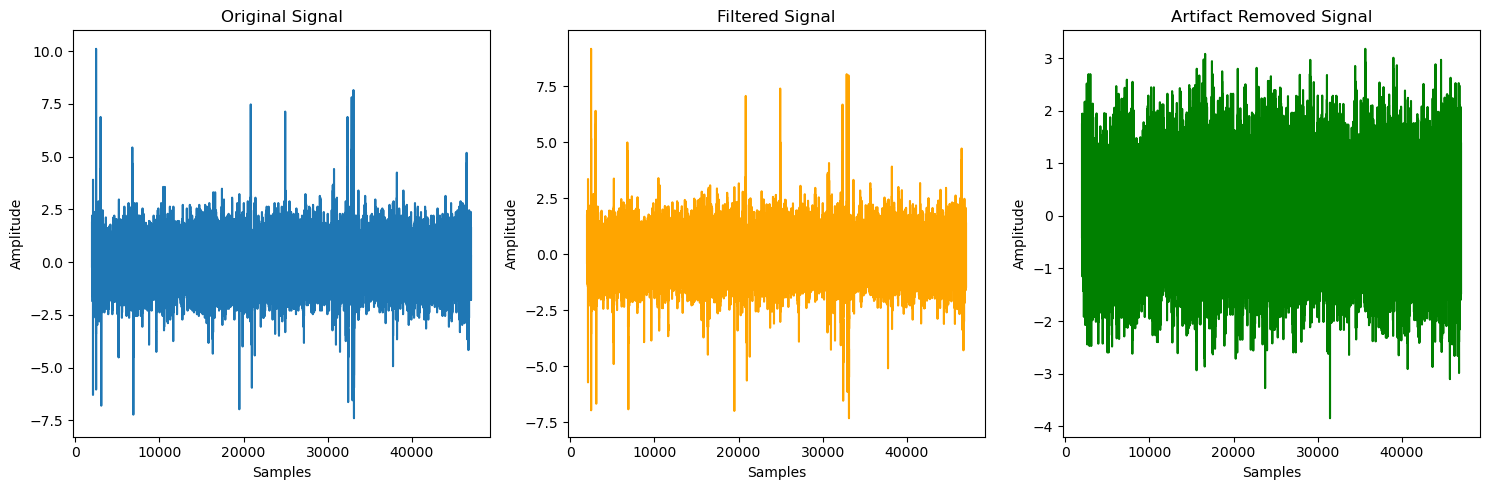

In [166]:
import matplotlib.pyplot as plt

# Plot the original, filtered, and artifact removed signals for comparison
plt.figure(figsize=(15, 5))

# Original signal
plt.subplot(1, 3, 1)
plt.plot(af8['AF8_normal'], label='Original')
plt.title('Original Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Filtered signal
plt.subplot(1, 3, 2)
plt.plot(af8['AF8_filt'], label='Filtered', color='orange')
plt.title('Filtered Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Artifact removed signal
plt.subplot(1, 3, 3)
plt.plot(af8['AF8_artif_removed'], label='Artifact Removed', color='green')
plt.title('Artifact Removed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

### Bandpass filtering

In [167]:
# Parameters
lowcut = 0.5
highcut = 50.0
fs = 256  
filter_order = 5

# Butterworth filter
nyquist_freq = 0.5 * fs
low = lowcut / nyquist_freq
high = highcut / nyquist_freq
b, a = butter(filter_order, [low, high], btype="band")
af8['AF8_bandpassed'] = filtfilt(b, a, af8['AF8_artif_removed'])

### Normalization

In [168]:
mean = af8['AF8_bandpassed'].mean()
std = af8['AF8_bandpassed'].std()
af8['AF8_preprocessed'] = (af8['AF8_bandpassed'] - mean) / std

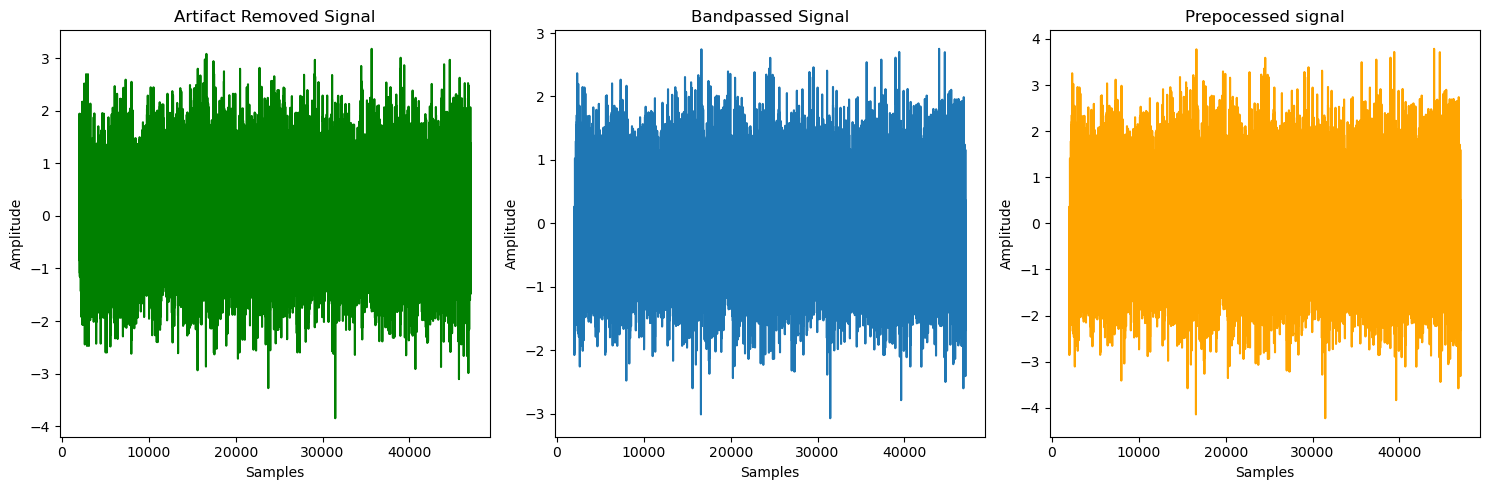

In [169]:
import matplotlib.pyplot as plt

# Plot the original, filtered, and artifact removed signals for comparison
plt.figure(figsize=(15, 5))

# Artifact removed signal
plt.subplot(1, 3, 1)
plt.plot(af8['AF8_artif_removed'], label='Artifact Removed', color='green')
plt.title('Artifact Removed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Original signal
plt.subplot(1, 3, 2)
plt.plot(af8['AF8_bandpassed'], label='Bandpassed')
plt.title('Bandpassed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Filtered signal
plt.subplot(1, 3, 3)
plt.plot(af8['AF8_preprocessed'], label='Prepocessed', color='orange')
plt.title('Prepocessed signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')



plt.tight_layout()
plt.show()

### Segmentation

In [170]:
fs = 256

segment_length = 0.8 # seconds
segment_samples = int(segment_length * fs)

num_segments = len(af8['AF8_preprocessed']) // segment_samples
segments = []
for i in range(num_segments):
    start = i * segment_samples
    end = start + segment_samples
    segment = af8['AF8_preprocessed'][start:end].values
    segments.append(segment)

### Discrete Wavelet Transform

In [171]:
def decompose_segment(segment, wavelet='sym3', max_level=5):
    if max_level is None:
        max_level = pywt.dwt_max_level(len(segment), wavelet)
    
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(segment, wavelet, level=max_level)

    bands = {'delta': None, 'theta': None, 'alpha': None, 'beta': None, 'gamma': None}

    # Start from gamma to match Zhang et al.
    bands['gamma'] = pywt.upcoef('d', coeffs[1], wavelet, level=max_level, take=len(segment))

    for i in range(2, max_level + 1):
        if i == max_level:
            # Extract delta band from the last level approximation coefficients
            bands['delta'] = pywt.upcoef('a', coeffs[-1], wavelet, level=1, take=len(segment))
        else:
            # Extract other bands by reconstructing from specific detail coefficients
            band_name = {2: 'beta', 3: 'alpha', 4: 'theta'}[i]
            bands[band_name] = pywt.upcoef('d', coeffs[i], wavelet, level=max_level-i+1, take=len(segment))

    return bands
    

In [172]:
all_segments_bands = [decompose_segment(segment) for segment in segments]

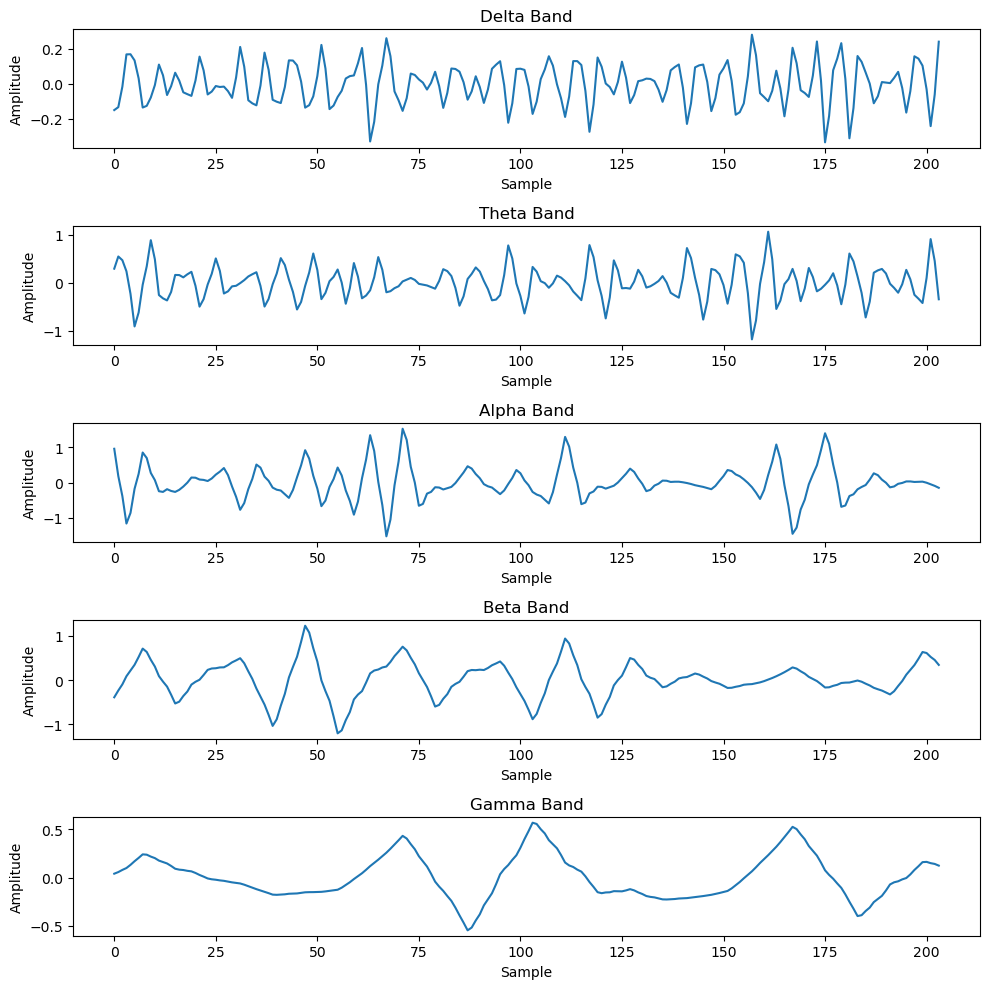

In [173]:
import matplotlib.pyplot as plt

# Assuming `all_segments_bands` is a list of dictionaries, 
# with each dictionary containing the decomposed bands for each segment
first_segment_bands = all_segments_bands[0]  # Get the bands for the first segment

# Define the number of subplots based on the number of bands
num_bands = len(first_segment_bands)
fig, axes = plt.subplots(num_bands, 1, figsize=(10, 2 * num_bands))

# Plot each band in a separate subplot
for i, (band_name, band_signal) in enumerate(first_segment_bands.items()):
    ax = axes[i] if num_bands > 1 else axes  # Handle the case of a single subplot
    ax.plot(band_signal)
    ax.set_title(f"{band_name.capitalize()} Band")
    ax.set_xlabel("Sample")
    ax.set_ylabel("Amplitude")

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


### Feature Computation

In [174]:
def approximate_entropy(segment, m=2, r=None):
    if not r:
        r = 0.2 * np.std(segment)
    
    def phi(m):
        x = np.array([segment[j:j+m] for j in range(len(segment) - m + 1)])
        C = np.sum([np.sum(np.abs(x - x[i]) <= r, axis=1) / (len(segment) - m + 1) for i in range(len(segment) - m + 1)], axis=0) / (len(segment) - m + 1)
        return np.sum(np.log(C)) / (len(segment) - m + 1)
    
    return np.abs(phi(m) - phi(m + 1))


def total_variation(signal):
    return np.sum(np.abs(np.diff(signal)))

def standard_deviation(signal):
    return np.std(signal)

def energy(signal):
    return np.sum(np.square(signal))

def skewness(signal):
    return skew(signal)

In [175]:
def approximate_entropy(signal, m=2, r=None):
    """
    Calculate the approximate entropy of a signal.

    Parameters:
    - signal: The input signal (list or numpy array).
    - m: The length of compared run of data (embedding dimension).
    - r: The filtering level (similarity criterion), if None, it is set to 0.2 times the standard deviation of the signal.

    Returns:
    - The approximate entropy of the signal.
    """

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m, U, N):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        # Adding a small constant (e.g., 1e-10) to avoid log(0)
        C = [sum([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) + 1e-10 for x_i in x]
        denominator = N - m + 1.0
        if denominator <= 0:
            raise ValueError("Invalid calculation: denominator is zero or negative.")

        return sum(np.log(C)) / denominator

    # Ensure 'signal' is a numpy array
    U = np.array(signal)
    N = len(U)

    # Set the similarity criterion 'r' if it is not provided
    if r is None:
        r = 0.2 * np.std(signal)

    # Calculate approximate entropy
    return abs(_phi(m + 1, U, N) - _phi(m, U, N))


In [176]:
# Define bands and features for clarity and extensibility
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Calculate features for each segment and store them
features_data = []
for i in range(len(all_segments_bands)):
    segment_features = {}
    for band in bands:
        segment_features[f'{band}_approx_entropy'] = approximate_entropy(all_segments_bands[i][band])
        segment_features[f'{band}_total_variation'] = total_variation(all_segments_bands[i][band])
        segment_features[f'{band}_standard_deviation'] = standard_deviation(all_segments_bands[i][band])
        segment_features[f'{band}_energy'] = energy(all_segments_bands[i][band])
        segment_features[f'{band}_skewness'] = skewness(all_segments_bands[i][band])

    features_data.append(segment_features)

# Now, for each segment, append features from preceding 9 windows
augmented_features_data = []

for i in range(len(features_data)):
    augmented_features = {}
    for j in range(max(0, i-9), i+1):
        for key, value in features_data[j].items():
            # Adjust the key to include the window index relative to the current segment
            augmented_key = f'{key}_win{j-i}'
            augmented_features[augmented_key] = value
            
    augmented_features_data.append(augmented_features)

# Create a DataFrame from the augmented features data
features_df = pd.DataFrame(augmented_features_data)

# Display the DataFrame structure
features_df.head(15)

,delta_approx_entropy_win0,delta_total_variation_win0,delta_standard_deviation_win0,delta_energy_win0,delta_skewness_win0,theta_approx_entropy_win0,theta_total_variation_win0,theta_standard_deviation_win0,theta_energy_win0,theta_skewness_win0,...,beta_approx_entropy_win-9,beta_total_variation_win-9,beta_standard_deviation_win-9,beta_energy_win-9,beta_skewness_win-9,gamma_approx_entropy_win-9,gamma_total_variation_win-9,gamma_standard_deviation_win-9,gamma_energy_win-9,gamma_skewness_win-9
0,0.704884,19.399286,0.113904,2.646786,-0.190020,0.629059,53.972838,0.340158,23.609001,-0.009801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.729003,15.140401,0.089980,1.651794,0.033005,0.721271,52.232114,0.332673,22.578121,0.070249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.724436,15.073387,0.093493,1.783171,0.109420,0.711412,56.651009,0.398029,32.321819,0.192730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.717596,15.820266,0.095606,1.864673,0.411016,0.685406,51.597071,0.334963,22.891394,0.106928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.766314,16.024338,0.096863,1.914039,0.030289,0.655252,46.869043,0.303796,18.828292,0.153925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.692728,12.651907,0.075572,1.165123,-0.160542,0.684904,39.088359,0.242791,12.025275,-0.110942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.754357,17.077498,0.108344,2.394628,-0.094896,0.734803,49.164953,0.319677,20.848368,-0.316336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.682594,14.385840,0.089498,1.634060,0.039150,0.703154,51.890599,0.331527,22.421683,0.118351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.715355,14.201632,0.085144,1.478887,0.162776,0.759375,41.376802,0.261997,14.003164,0.084018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.750299,19.898227,0.118483,2.863887,0.200386,0.637137,54.440546,0.337488,23.235262,0.014790,...,0.530712,24.144305,0.401584,32.947090,-0.235698,0.437344,6.472083,0.222996,10.150486,0.358811
